In [65]:
# Imports
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [72]:
# Parameters for the simulation
K = 80
S0= 100
T = 1
r = 0.05
lmbda = 1
eta = 0.5
rho = -0.7
N = 2000
M = 3000
v0 = 0.04
v_mean = 0.04

1. Discrétiser l’EDS de Black & Scholes avec un schéma d’Euler et un schéma de Milstein. Illustrer les convergences et retrouver les ordres forts et faibles de chacun des schémas.

L'équation de Black & Scholes s'écrit:

$$
dS_t = \mu S_t dt + \sigma S_t dB_t
$$

Soit $T \gt 0$ et $M \in \mathbb{N}$ fixés quelconques. On pose $h = \frac{T}{M}$ le pas de la discrétisation. La discrétisation avec un schéma d'Euler donne:

$$
\forall j \in [\![1, M]\!], \hat{S}_{jh} = \hat{S}_{(j-1)h} + \mu \hat{S}_{(j-1)h}h + \sigma \hat{S}_{(j-1)h} \sqrt{h}Z_j
$$

Avec le schéma de Milstein, on obtient:

$$
\forall j \in [\![1, M]\!], \hat{S}_{jh} = \hat{S}_{(j-1)h} + \mu \hat{S}_{(j-1)h}h + \sigma \hat{S}_{(j-1)h} \sqrt{h}Z_j + \frac{1}{2}\sigma^2 \hat{S}_{(j-1)h}(Z_j^2 - 1)h
$$

2. Implémenter le pricing d'un call standard dans le modèle de Heston par Monte Carlo, avec le schéma d'Euler simple proposé.

In [61]:
def MC_heston(S0: float, T: float, r: float, N: int, M: int, v0: float, v_mean: float, lmbda: float, eta: float, rho: float) -> np.array:
    """
    Monte Carlo simulation with Heston model

    **INPUT:**
    - S0: initial price of the underlying
    - T: Horizon
    - r: risk-free rate
    - N: Number of simulations to perform
    - M: Number of steps in discretization
    - v0: initial variance
    - v_m: variance average
    - lmbda: coefficient of the dt part of the CIR process
    - eta: coefficient of the dBt part of the CIR process
    - rho: correlation between the two brownian motions

    **OUTPUT:**
    - S_t: simulated trajectories of the underlying with the Heston model
    """
    # Initialization of useful params
    dt = T/M
    Xt = np.zeros((N, M))
    Xt[:, 0] = np.log(S0)
    vt = np.zeros((N, M))
    vt[:, 0] = v0

    # Simulation of the correlated brownian motions
    m_cov = [[1, rho], [rho, 1]]
    l_mean = [0, 0]
    b_ms = np.random.multivariate_normal(mean=l_mean, cov=m_cov, size=(N, M))
    z1, z2 = b_ms[:, :, 0], b_ms[:, :, 1]

    # Calculation of the log returns and variances for each step
    for step in range(1, M):
        Xt[:, step] = Xt[:, step-1] + (r - (1/2) * vt[:, step-1]) * dt + np.sqrt(np.abs(vt[:, step-1]) * dt) * z1[:, step]
        vt[:, step] = vt[:, step-1] - lmbda * (vt[:, step-1] - v_mean) * dt + eta * np.sqrt(np.abs(vt[:, step-1]) * dt) * z2[:, step]
    St = np.exp(Xt)
    return St

St = MC_heston(S0, T, r, N, M, v0, v_mean, lmbda, eta, rho)  

def MC_call_price(St: np.array, K: float) -> float:
    """
    Calculates the european call price based on the given MC simulated
    trajectories of a particular model

    **INPUT**
    - St: Monte Carlo simulations of the underlying performed using a model

    **OUTPUT**
    - call_price: price of the european call worked out using Monte Carlo simulation
    """
    
    return np.mean(np.exp(-r * T) * np.maximum(St[:, -1] - K, 0))
    
print(MC_call_price(St=St, K=K))

25.546870397680657


3. Implémenter le calcul de la volatilité implicite de Black & Scholes par dichotomie. On peut se ramener à un intervalle borné en écrivant $S_t = \frac{x}{1 - x}, x \in [0, 1]$

In [64]:
def call_price_black_scholes(K, T, S0, r, sigma):
    """
    Calculate the Black-Scholes price of a European call option.
    Parameters:
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
    Returns:
        float: The Black-Scholes price of the European call option.
    
    """
    d1 = 1 / (sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + sigma**2 / 2) * T)
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_vol(C_market, S0, K, T, r, eps = 0.01):
    """
    Calculates the implied volatility of a Black & Scholes call
    using a dichotomy method

    **INPUT**
    - C_market: European call market price
    - S0: Current price of the underlying
    - K: Strike price of the call
    - T: maturity of the call
    - r: risk free rate
    - eps: error margin for when to stop the dichotomy

    **OUTPUT**

    """
    # Testing if implied volatility can be worked out

    lower_call_bound = np.maximum(S0 - K * np.exp(-r * T), 0)
    upper_call_bound = S0
    if (C_market < lower_call_bound) or (C_market > upper_call_bound):
        print("Market price is out of bounds for unique volatility")
        return None
    
    # Initialization of lower and upper bounds for sigma
    l_sigma = 0.1
    while call_price_black_scholes(K=K, T=T, S0=S0, r=r, sigma=l_sigma) > C_market:
        l_sigma /=2
    u_sigma = 0.4
    while call_price_black_scholes(K=K, T=T, S0=S0, r=r, sigma=u_sigma) < C_market:
        u_sigma *= 2

    # Initialization
    sigma = (l_sigma + u_sigma)/2
    c_est = call_price_black_scholes(K=K, T=T, S0=S0, r=r, sigma=sigma)
    c_diff = C_market - c_est
    

    while (abs(c_diff) > eps):
        if c_diff > 0:
            # volatility is too low in this case
            l_sigma = sigma
        else:
            # volatility is too high
            u_sigma = sigma
        sigma = (l_sigma + u_sigma) / 2
        c_est = call_price_black_scholes(K=K, T=T, S0=S0, r=r, sigma=sigma)
        c_diff = C_market - c_est
    return sigma

print(implied_vol(25.546870397680657, S0, K, T, r))

0.25703125000000004


4. Tracer un exemple de smile de volatilité dans le modèle de Heston. Commenter.

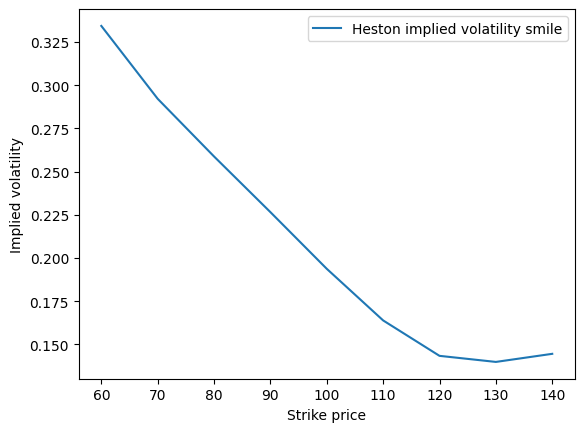

In [99]:
l_k = [10*k for k in range(6, 15)]
St = MC_heston(S0, T, r, N, M, v0, v_mean, lmbda, eta, rho)
l_implied_vols = []
for k in l_k:
    C_heston = MC_call_price(St=St, K=k)
    k_implied_vol = implied_vol(C_market=C_heston, S0=S0, K=k, T=T, r=r)
    l_implied_vols.append(k_implied_vol)
plt.plot(l_k, l_implied_vols, label="Heston implied volatility smile")
plt.ylabel("Implied volatility")
plt.xlabel("Strike price")
plt.legend()
plt.show()

Nous pouvons observer que plus le strike price est élevé, plus la volatilité implicite est faible, et ce même si l'option est out of the money.